# **🌐 Isochronic Network**

In this notebook, we create a network of stops, with edges between them representing means of transports that can be used to go from one stop to another. We also add the travel time between stops as an attribute of the edges.

In [1]:
import pyproj
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Geod
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic

## **📊 Process the Data**

In [2]:
TRANSPORTS_PATH = '../../data/processed/transports_v2.parquet'
transports = pd.read_parquet(TRANSPORTS_PATH)
transports.head()

,trip_id,product_id,line_text,transport_type,stop_id,arrival_time,departure_time,mean_arrival_delay,mean_departure_delay,median_arrival_delay,median_departure_delay,std_arrival_delay,std_departure_delay,n_arrival_delay,n_departure_delay,n_cancelled,n_through_trip,n_additional_trip,n_entries
0,80:06____:17171:000,Train,RB,RB,8500090,14:50:00,None,293.939394,NaN,120.0,NaN,388.229414,NaN,68,0,4,0,0,104
1,80:06____:17261:000,Train,RB,RB,8500090,None,15:53:00,NaN,61.621622,NaN,0.0,NaN,129.218022,0,9,1,0,0,104
2,80:800693:3053:000,Train,IRE3,IRE,8503424,11:58:00,12:00:00,151.539474,127.605263,41.0,19.0,627.797068,622.499501,60,73,2,0,0,78
4,80:sbg034:14004,Bus,Bus7349,B,8573327,09:07:00,None,2.400000,NaN,0.0,NaN,29.443320,NaN,5,0,0,0,0,100
6,80:sbg034:55413,Bus,Bus7349,B,8503474,00:19:00,00:20:00,138.000000,96.000000,180.0,120.0,107.025910,84.852814,70,68,0,0,0,100


In [3]:
transports = transports[['trip_id', 'stop_id', 'arrival_time', 'departure_time']]

# Get new time column
transports['time'] = transports['arrival_time'].fillna(transports['departure_time'])
transports = transports.drop(['arrival_time', 'departure_time'], axis=1)

transports = transports.drop_duplicates()
print(f'Number of entries: {len(transports):_}')

Number of entries: 5_519_437


In [4]:
def remove_single_stop_journeys(data):
    """
    Remove journeys that only have the same stop id in each of its entries.
    """
    new_data = data.copy()
    # Group by 'trip_id' and check if all 'stop_id' values are the same
    grouped_data = new_data.groupby('trip_id').agg({
        'stop_id': lambda x: len(x.unique()) == 1
    }).reset_index().rename(columns={'stop_id': 'single_stop'})

    # Merge the grouped_data with the original DataFrame
    data_with_single_stop = new_data.merge(grouped_data, on='trip_id')

    # Filter out the rows with single_stop == True
    filtered_data = data_with_single_stop[~data_with_single_stop['single_stop']].drop(columns=['single_stop'])

    return filtered_data

transports = remove_single_stop_journeys(transports)
print(f'Number of entries: {len(transports):_}')
transports.sort_values(['trip_id', 'time']).head()

Number of entries: 5_517_790


,trip_id,stop_id,time
5510535,80:800693:3040:000,8503424,06:58:00
5510537,80:800693:3040:000,8503424,07:58:00
5510534,80:800693:3040:000,8500090,08:15:00
5510536,80:800693:3040:000,8500090,09:15:00
5196961,80:800693:3041:000,8500090,05:58:00


In [5]:
def enhance_trip_id(data):
    new_data = data.copy()

    # Sort data by trip_id, stop_id, and time
    new_data = new_data.sort_values(['trip_id', 'stop_id', 'time'])

    # Group data by trip_id and stop_id and assign an increasing number for each group
    new_data['group_number'] = new_data \
        .groupby(['trip_id', 'stop_id']) \
        .cumcount() + 1

    # Update the trip_id by appending the group_number
    new_data['trip_id'] = new_data['trip_id'].astype(str) + '_' + new_data['group_number'].astype(str)

    # Remove the group_number column
    new_data = new_data.drop(columns=['group_number'])

    return new_data

transports = enhance_trip_id(transports)
print(f'Number of entries: {len(transports):_}')
transports.sort_values(['trip_id', 'time']).head()

Number of entries: 5_517_790


,trip_id,stop_id,time
5510535,80:800693:3040:000_1,8503424,06:58:00
5510534,80:800693:3040:000_1,8500090,08:15:00
5510537,80:800693:3040:000_2,8503424,07:58:00
5510536,80:800693:3040:000_2,8500090,09:15:00
5196961,80:800693:3041:000_1,8500090,05:58:00


In [6]:
def add_trip_index(data):
    new_data = data.copy()
    # Add a temporary unique identifier to the original data
    new_data['_temp_id'] = np.arange(len(data))
    
    trip_stops = new_data \
        .sort_values(['trip_id', 'time']) \
        .groupby('trip_id') \
        .agg({
            'stop_id': lambda x: list(x),
            '_temp_id': lambda x: list(x)
        }) \
        .rename(columns={
            'stop_id': 'stop_ids', 
        }) \
        .reset_index()

    # Add indexes
    trip_stops['stop_indexes'] = trip_stops['stop_ids'].apply(lambda x: list(range(len(x))))
    
    # Create a new DataFrame with stop_ids, temp_ids and their corresponding indexes
    exploded_trip_stops = pd.concat(
        [pd.DataFrame(
            {'trip_id': x['trip_id'], 'stop_id': x['stop_ids'], '_temp_id': x['_temp_id'], 'trip_index': list(range(len(x['stop_ids'])))}
        ) for i, x in trip_stops.iterrows()], ignore_index=True)
    
    # Merge with the original DataFrame (using the temporary unique identifier)
    result = new_data.merge(exploded_trip_stops, on=['trip_id', 'stop_id', '_temp_id'])

    # Remove the temporary unique identifier column
    result = result.drop(columns=['_temp_id'])

    return result

transports = add_trip_index(transports)
print(f'Number of entries: {len(transports):_}')
transports.sort_values(['trip_id', 'time']).head()

Number of entries: 5_517_790


,trip_id,stop_id,time,trip_index
2,80:800693:3040:000_1,8503424,06:58:00,0
0,80:800693:3040:000_1,8500090,08:15:00,1
3,80:800693:3040:000_2,8503424,07:58:00,0
1,80:800693:3040:000_2,8500090,09:15:00,1
4,80:800693:3041:000_1,8500090,05:58:00,0


In [7]:
def create_stop_pairs(data):
    # Create a new DataFrame
    new_data = data.copy()

    # Add a new column next_stop_id that contains the stop_id of the trip_index i+1 for each trip_id
    new_data['next_stop_id'] = new_data.groupby('trip_id')['stop_id'].shift(1)

    # Do the same for next_time
    new_data['next_time'] = new_data.groupby('trip_id')['time'].shift(1)

    # Remove rows with missing next_stop_id
    new_data = new_data.dropna(subset=['next_stop_id'])

    return new_data

stop_pairs = create_stop_pairs(transports)
print(f'Number of entries: {len(stop_pairs):_}')
stop_pairs.sort_values(['trip_id', 'time']).head()

Number of entries: 5_161_395


,trip_id,stop_id,time,trip_index,next_stop_id,next_time
2,80:800693:3040:000_1,8503424,06:58:00,0,8500090.0,08:15:00
3,80:800693:3040:000_2,8503424,07:58:00,0,8500090.0,09:15:00
6,80:800693:3041:000_1,8503424,07:27:00,1,8500090.0,05:58:00
7,80:800693:3041:000_2,8503424,08:27:00,1,8500090.0,06:58:00
10,80:800693:3042:000_1,8503424,07:58:00,0,8500090.0,09:12:00


In [8]:
# Get the difference in time between the current stop and the next stop
stop_pairs['time'] = pd.to_datetime(stop_pairs['time'])
stop_pairs['next_time'] = pd.to_datetime(stop_pairs['next_time'])
stop_pairs['d_time'] = (stop_pairs['next_time'] - stop_pairs['time']).dt.total_seconds()
stop_pairs.head()

,trip_id,stop_id,time,trip_index,next_stop_id,next_time,d_time
2,80:800693:3040:000_1,8503424,2023-05-15 06:58:00,0,8500090.0,2023-05-15 08:15:00,4620.0
3,80:800693:3040:000_2,8503424,2023-05-15 07:58:00,0,8500090.0,2023-05-15 09:15:00,4620.0
6,80:800693:3041:000_1,8503424,2023-05-15 07:27:00,1,8500090.0,2023-05-15 05:58:00,-5340.0
7,80:800693:3041:000_2,8503424,2023-05-15 08:27:00,1,8500090.0,2023-05-15 06:58:00,-5340.0
10,80:800693:3042:000_1,8503424,2023-05-15 07:58:00,0,8500090.0,2023-05-15 09:12:00,4440.0


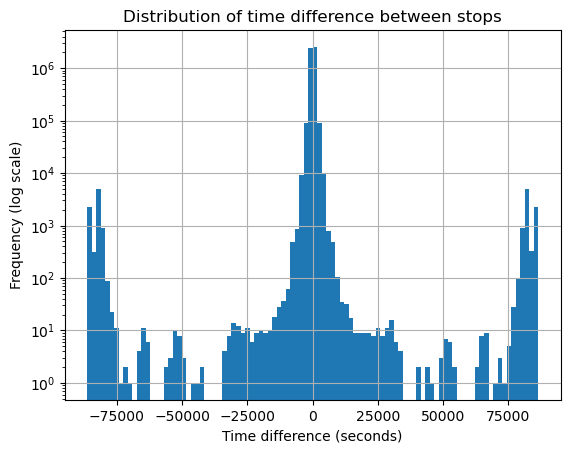

In [9]:
stop_pairs.d_time.hist(bins=100, log=True)
plt.title('Distribution of time difference between stops')
plt.xlabel('Time difference (seconds)')
plt.ylabel('Frequency (log scale)')
plt.show()

In [10]:
# Inverse the stops if d_time is negative
stop_pairs['old_stop_id'] = stop_pairs['stop_id']
stop_pairs['stop_id'] = np.where(stop_pairs['d_time'] < 0, stop_pairs['next_stop_id'], stop_pairs['stop_id'])
stop_pairs['next_stop_id'] = np.where(stop_pairs['d_time'] < 0, stop_pairs['old_stop_id'], stop_pairs['next_stop_id'])
stop_pairs['d_time'] = np.where(stop_pairs['d_time'] < 0, -stop_pairs['d_time'], stop_pairs['d_time'])
stop_pairs = stop_pairs.drop(columns=['old_stop_id'])

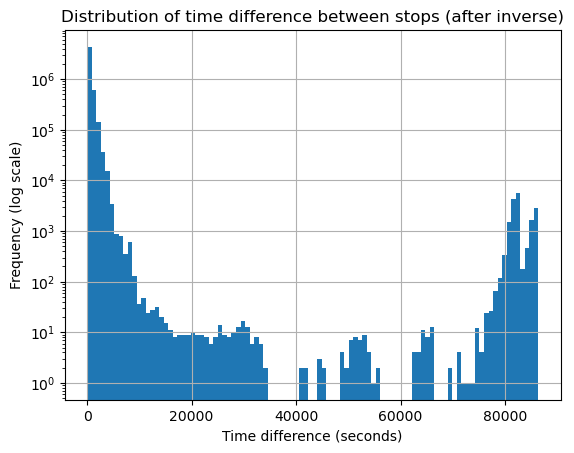

In [11]:
stop_pairs.d_time.hist(bins=100, log=True)
plt.title('Distribution of time difference between stops (after inverse)')
plt.xlabel('Time difference (seconds)')
plt.ylabel('Frequency (log scale)')
plt.show()

In [12]:
# Let us remove the outliers, as they are probably caused by errors in the data or trains that actually start before midnight and end after midnight the next day
stop_pairs = stop_pairs[stop_pairs['d_time'] < stop_pairs['d_time'].quantile(0.99)]

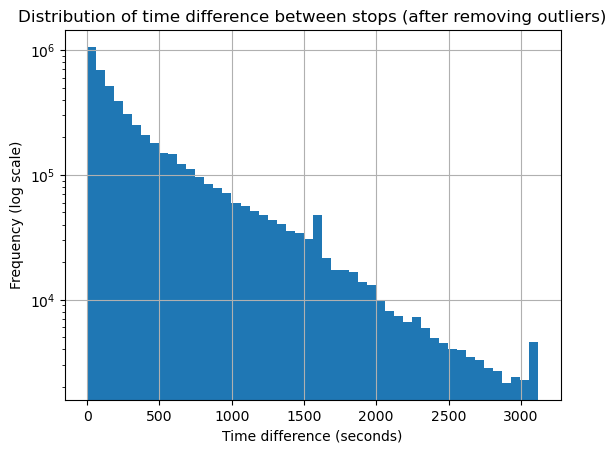

In [13]:
stop_pairs.d_time.hist(bins=50, log=True)
plt.title('Distribution of time difference between stops (after removing outliers)')
plt.xlabel('Time difference (seconds)')
plt.ylabel('Frequency (log scale)')
plt.show()

In [14]:
stop_pairs = stop_pairs[['stop_id', 'next_stop_id', 'd_time']]
stop_pairs.head()

,stop_id,next_stop_id,d_time
119,8503424.0,8500090.0,1560.0
142,8503470.0,8503474.0,300.0
143,8503470.0,8503474.0,300.0
144,8573327.0,8503474.0,720.0
145,8573327.0,8503474.0,720.0


In [15]:
STOPS_PATH = '../../data/processed/stops.csv'
stops = pd.read_csv(STOPS_PATH)
stops.head()

,stop_id,stop_name,stop_lon,stop_lat,transport_type,city,canton,is_bus_stop,is_tram_stop,is_train_stop,...,is_rack_railway_stop,is_boat_stop,x_fa2,y_fa2,x_geo,y_geo,indegree,outdegree,degree,betweenness_centrality
0,8500010,Basel SBB,2611363.0,1266310.0,Train,Basel,BS,False,False,True,...,False,False,3224.670618,3971.930148,8747.787053,1083.724166,0.0,179568.0,179568.0,0.000000
1,8500016,Basel St. Johann,2610076.0,1268853.0,Train,Basel,BS,False,False,True,...,False,False,3197.918906,3963.147252,8740.453774,1098.214087,43662.0,43930.0,87592.0,0.000000
2,8500020,Muttenz,2615758.0,1264783.0,Train,Muttenz,BL,False,False,True,...,False,False,3214.033084,3969.759300,8772.829603,1075.023376,20739.0,20603.0,41342.0,2740.819048
3,8500021,Pratteln,2618994.0,1263578.0,Train,Pratteln,BL,False,False,True,...,False,False,3198.389545,3981.655233,8791.268213,1068.157330,52469.0,52786.0,105255.0,9347.652381
4,8500023,Liestal,2622064.0,1259341.0,Train,Liestal,BL,False,False,True,...,False,False,3280.207836,3979.718988,8808.760961,1044.015059,10333.0,10333.0,20666.0,7780.250000


In [16]:
# Get latitudes and longitudes for each stop
stop_pairs = stop_pairs.merge(stops[['stop_id', 'stop_lat', 'stop_lon']], left_on='stop_id', right_on='stop_id', how='left')
stop_pairs = stop_pairs.merge(stops[['stop_id', 'stop_lat', 'stop_lon']], left_on='next_stop_id', right_on='stop_id', how='left', suffixes=('', '_next'))
stop_pairs = stop_pairs.rename(columns={'stop_lat': 'lat', 'stop_lon': 'lon', 'stop_lat_next': 'next_lat', 'stop_lon_next': 'next_lon'})
stop_pairs = stop_pairs.drop(columns=['stop_id_next'])
stop_pairs.head()

,stop_id,next_stop_id,d_time,lat,lon,next_lat,next_lon
0,8503424.0,8500090.0,1560.0,1283756.0,2689636.0,1268525.0,2612665.0
1,8503470.0,8503474.0,300.0,1281755.0,2704572.0,1284990.0,2703100.0
2,8503470.0,8503474.0,300.0,1281755.0,2704572.0,1284990.0,2703100.0
3,8573327.0,8503474.0,720.0,1279318.0,2706456.0,1284990.0,2703100.0
4,8573327.0,8503474.0,720.0,1279318.0,2706456.0,1284990.0,2703100.0


In [17]:
# Map (CH1903 / LV03) coordinates to (WGS84) coordinates
# Define the source (CH1903 / LV03) and target (WGS84) coordinate systems
source_crs = pyproj.CRS("EPSG:2056")  # Swiss Coordinate System (CH1903 / LV03)
target_crs = pyproj.CRS("EPSG:4326")   # WGS84 (latitude and longitude)

# Define the transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert the coordinates
# Inverse both because the source coordinates are in (y, x) order
stop_pairs['lat'], stop_pairs['lon'] = transformer.transform(stop_pairs['lon'].to_list(), stop_pairs['lat'].to_list())
stop_pairs['next_lat'], stop_pairs['next_lon'] = transformer.transform(stop_pairs['next_lon'].to_list(), stop_pairs['next_lat'].to_list())

# Check the transformed coordinates
stop_pairs.head()

,stop_id,next_stop_id,d_time,lat,lon,next_lat,next_lon
0,8503424.0,8500090.0,1560.0,47.698282,8.632755,47.567311,7.606922
1,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376
2,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376
3,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376
4,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376


In [18]:
geod = Geod(ellps='WGS84')

def calculate_distance(row):
    _, _, distance = geod.inv(row['lon'], row['lat'],
                              row['next_lon'], row['next_lat'])
    return distance

# Apply the function to the DataFrame
stop_pairs['distance'] = stop_pairs.apply(calculate_distance, axis=1)
stop_pairs['speed'] = stop_pairs['distance'] / (stop_pairs['d_time']) * 3.6
stop_pairs = stop_pairs[stop_pairs['d_time'] != 0]
stop_pairs.head()

,stop_id,next_stop_id,d_time,lat,lon,next_lat,next_lon,distance,speed
0,8503424.0,8500090.0,1560.0,47.698282,8.632755,47.567311,7.606922,78457.295860,181.055298
1,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376,3553.824345,42.645892
2,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376,3553.824345,42.645892
3,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376,6589.877242,32.949386
4,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376,6589.877242,32.949386


In [19]:
stop_pairs.head()

,stop_id,next_stop_id,d_time,lat,lon,next_lat,next_lon,distance,speed
0,8503424.0,8500090.0,1560.0,47.698282,8.632755,47.567311,7.606922,78457.295860,181.055298
1,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376,3553.824345,42.645892
2,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376,3553.824345,42.645892
3,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376,6589.877242,32.949386
4,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376,6589.877242,32.949386


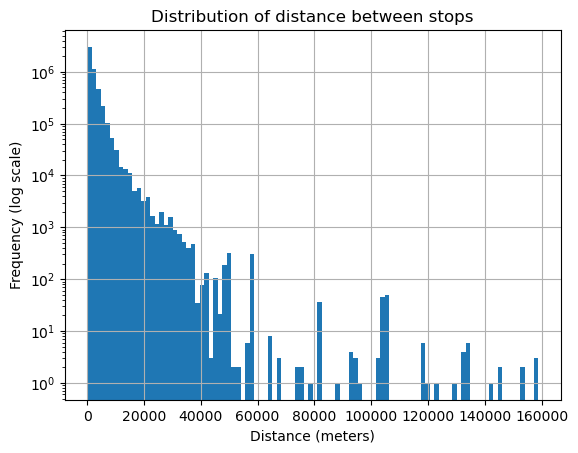

In [20]:
stop_pairs.distance.hist(bins=100, log=True)
plt.title('Distribution of distance between stops')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency (log scale)')
plt.show()

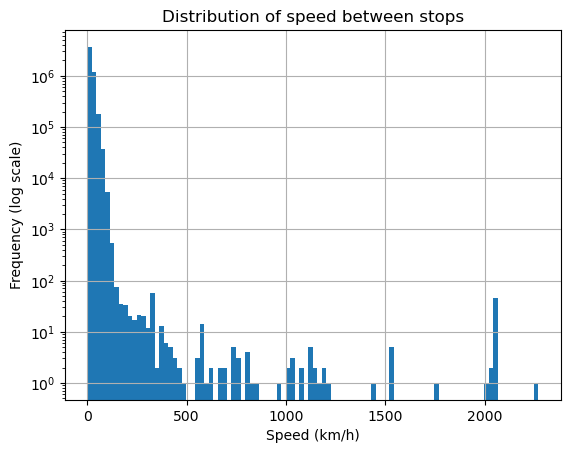

In [21]:
stop_pairs.speed.hist(bins=100, log=True)
plt.title('Distribution of speed between stops')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency (log scale)')
plt.show()

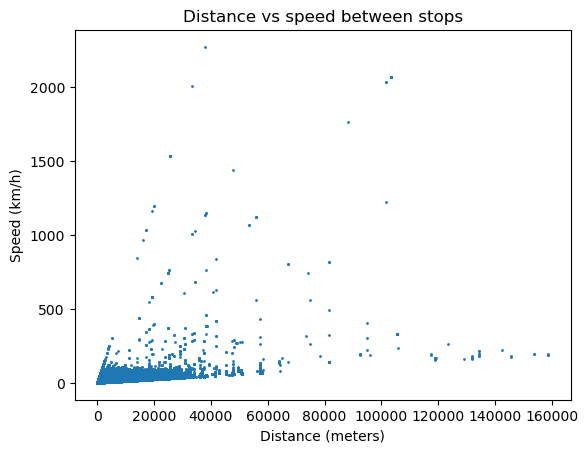

In [22]:
plt.scatter(stop_pairs.distance, stop_pairs.speed, s=1)
plt.title('Distance vs speed between stops')
plt.xlabel('Distance (meters)')
plt.ylabel('Speed (km/h)')
plt.show()

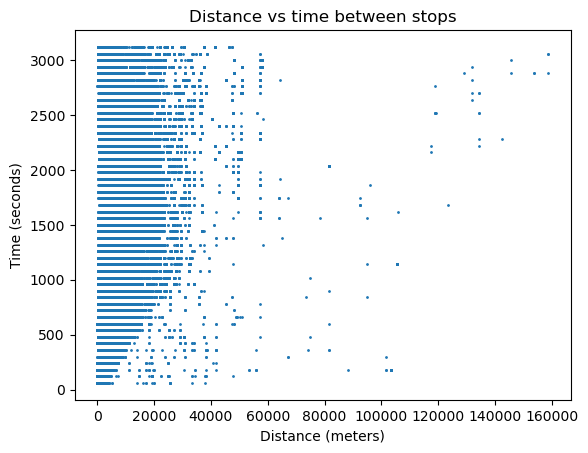

In [23]:
plt.scatter(stop_pairs.distance, stop_pairs.d_time, s=1)
plt.title('Distance vs time between stops')
plt.xlabel('Distance (meters)')
plt.ylabel('Time (seconds)')
plt.show()

In [24]:
# Remove speed outliers
stop_pairs = stop_pairs[stop_pairs['speed'] < stop_pairs['speed'].quantile(0.99)]

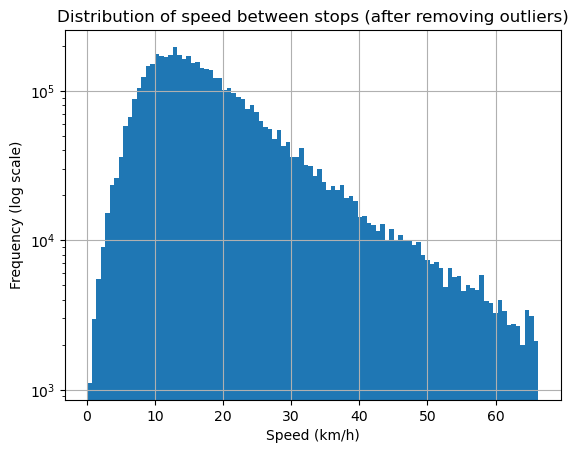

In [25]:
stop_pairs.speed.hist(bins=100, log=True)
plt.title('Distribution of speed between stops (after removing outliers)')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency (log scale)')
plt.show()

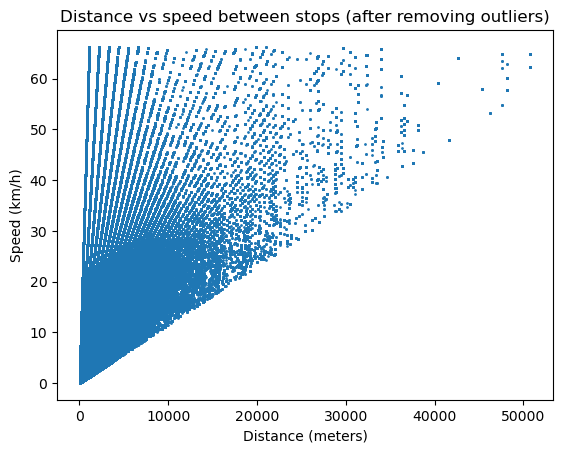

In [26]:
plt.scatter(stop_pairs.distance, stop_pairs.speed, s=1)
plt.title('Distance vs speed between stops (after removing outliers)')
plt.xlabel('Distance (meters)')
plt.ylabel('Speed (km/h)')
plt.show()

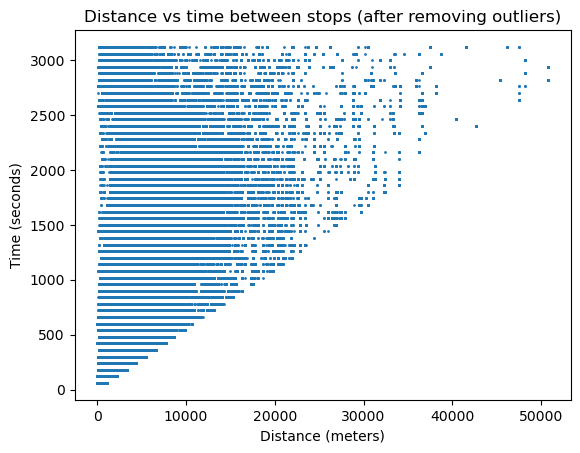

In [27]:
plt.scatter(stop_pairs.distance, stop_pairs.d_time, s=1)
plt.title('Distance vs time between stops (after removing outliers)')
plt.xlabel('Distance (meters)')
plt.ylabel('Time (seconds)')
plt.show()

In [28]:
print(f'Number of stop pairs: {len(stop_pairs):_}')
stop_pairs.head()

Number of stop pairs: 4_999_900


,stop_id,next_stop_id,d_time,lat,lon,next_lat,next_lon,distance,speed
1,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376,3553.824345,42.645892
2,8503470.0,8503474.0,300.0,47.678074,8.831221,47.707396,8.812376,3553.824345,42.645892
3,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376,6589.877242,32.949386
4,8573327.0,8503474.0,720.0,47.655858,8.855719,47.707396,8.812376,6589.877242,32.949386
5,8573327.0,8578397.0,120.0,47.655858,8.855719,47.659062,8.859932,476.555789,14.296674


In [29]:
# Get mean d_time for each stop pair
stop_pairs = stop_pairs \
    .groupby(['stop_id', 'next_stop_id', 'lat', 'lon', 'next_lat', 'next_lon']) \
    .agg({'d_time': 'min'}) \
    .reset_index()
stop_pairs.head()

,stop_id,next_stop_id,lat,lon,next_lat,next_lon,d_time
0,8500010.0,8500016.0,47.547414,7.589564,47.570305,7.572525,300.0
1,8500010.0,8500020.0,47.547414,7.589564,47.533590,7.647892,300.0
2,8500010.0,8500021.0,47.547414,7.589564,47.522667,7.690815,720.0
3,8500010.0,8500023.0,47.547414,7.589564,47.484465,7.731367,720.0
4,8500010.0,8500090.0,47.547414,7.589564,47.567311,7.606922,300.0


In [30]:
# Create node list, mix of stop and next_stop with concat
nodes = pd.DataFrame()
nodes['id'] = pd.concat([stop_pairs['stop_id'], stop_pairs['next_stop_id']])
nodes['lat'] = pd.concat([stop_pairs['lat'], stop_pairs['next_lat']])
nodes['lon'] = pd.concat([stop_pairs['lon'], stop_pairs['next_lon']])
nodes.reset_index(drop=True, inplace=True)
nodes.drop_duplicates(inplace=True)
nodes.head()

,id,lat,lon
0,8500010.0,47.547414,7.589564
10,8500016.0,47.570305,7.572525
11,8500020.0,47.533590,7.647892
13,8500021.0,47.522667,7.690815
17,8500022.0,47.501466,7.719104


In [31]:
edges = stop_pairs[['stop_id', 'next_stop_id', 'd_time']] \
    .rename(columns={'stop_id': 'source', 'next_stop_id': 'target', 'd_time': 'weight'})
edges['source'] = edges['source'].astype(int)
edges['target'] = edges['target'].astype(int)
edges.head()

,source,target,weight
0,8500010,8500016,300.0
1,8500010,8500020,300.0
2,8500010,8500021,720.0
3,8500010,8500023,720.0
4,8500010,8500090,300.0


In [32]:
len(edges)

56641

In [33]:
MAX_CLOSE_DISTANCE = 1000 # 1 km
CLOSE_WEIGHT = 1200 # 20 minutes

# Convert DataFrame to GeoDataFrame
nodes['geometry'] = nodes.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf = gpd.GeoDataFrame(nodes, geometry='geometry')

# Set up spatial index
sindex = gdf.sindex

# Define a function to find nearby nodes
def find_nearby(row, max_distance=MAX_CLOSE_DISTANCE):
    # Buffer the point
    buffered_point = row['geometry'].buffer(max_distance / 111320)  # convert meters to degrees

    # Find possible matches
    possible_matches_index = list(sindex.intersection(buffered_point.bounds))
    possible_matches = gdf.iloc[possible_matches_index]

    # Get exact matches
    exact_matches = possible_matches[possible_matches.intersects(buffered_point)]

    return pd.Series({'nearby_nodes': exact_matches['id'].tolist()})

# Apply the function to the DataFrame
gdf[['nearby_nodes']] = gdf.apply(find_nearby, axis=1)

In [34]:
gdf.head()

,id,lat,lon,geometry,nearby_nodes
0,8500010.0,47.547414,7.589564,POINT (7.58956 47.54741),"[8589300.0, 8589335.0, 8500161.0, 8589378.0, 8..."
10,8500016.0,47.570305,7.572525,POINT (7.57253 47.57031),"[8589303.0, 8588488.0, 8578144.0, 8588777.0, 8..."
11,8500020.0,47.533590,7.647892,POINT (7.64789 47.53359),"[8500256.0, 8517412.0, 8578193.0, 8500020.0, 8..."
13,8500021.0,47.522667,7.690815,POINT (7.69082 47.52267),"[8595705.0, 8595704.0, 8578353.0, 8595156.0, 8..."
17,8500022.0,47.501466,7.719104,POINT (7.71910 47.50147),"[8589423.0, 8595445.0, 8589402.0, 8588877.0, 8..."


In [35]:
# Explode the 'nearby_nodes' column
close_edges = gdf[['id', 'nearby_nodes']].explode('nearby_nodes')

# Rename the columns to be more descriptive
close_edges = close_edges.rename(columns={'id': 'source', 'nearby_nodes': 'target'})

# Add the 'weight' column
close_edges['weight'] = CLOSE_WEIGHT

# Remove any edges that have no target
close_edges = close_edges.dropna()

close_edges['source'] = close_edges['source'].astype(int)
close_edges['target'] = close_edges['target'].astype(int)

close_edges.head()

,source,target,weight
0,8500010,8589300,1200
0,8500010,8589335,1200
0,8500010,8500161,1200
0,8500010,8589378,1200
0,8500010,8589340,1200


In [36]:
# Merge the close edges with the original edges
edges = pd.concat([edges, close_edges])
len(edges)

212258

In [37]:
# Should be inderected, do the mean between source target set
# Make sure the smaller id is always the 'source'
edges[['source', 'target']] = np.sort(edges[['source', 'target']], axis=1)

# Calculate the mean weight for each pair of nodes
edges = edges.groupby(['source', 'target'], as_index=False)['weight'].mean()

len(edges)

110449

In [38]:
nodes = nodes[['id', 'lat', 'lon']].copy()
nodes['id'] = nodes['id'].astype(int)

In [39]:
# Save nodes in csv
NODES_DST_PATH = '../../data/processed/iso_nodes.csv'
EDGES_DST_PATH = '../../data/processed/iso_edges.csv'

nodes.to_csv(NODES_DST_PATH, index=False)
edges.to_csv(EDGES_DST_PATH, index=False)